<a href="https://colab.research.google.com/github/eagleonetwo/ProgrammingAssignment2/blob/master/kellysanalysisforcrypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import hashlib
import random
import pandas as pd
import numpy as np


In [13]:
# Simulate 10 trading nodes with 30 days of volume
np.random.seed(42)
nodes = [f"wallet_{i}" for i in range(10)]
dates = pd.date_range(end=pd.Timestamp.today(), periods=30)

data = []
for node in nodes:
    for date in dates:
        volume = np.random.exponential(scale=1000)
        return_rate = np.random.normal(loc=0.02, scale=0.1)  # daily ROI
        data.append({"node": node, "date": date, "volume": volume, "return": return_rate})

df = pd.DataFrame(data)


In [14]:
def hash_node_id(node_id):
    return hashlib.sha256(node_id.encode()).hexdigest()

df['node_hash'] = df['node'].apply(hash_node_id)


In [15]:
def compute_kelly(p, b):
    q = 1 - p
    return max((b * p - q) / b, 0)  # Clip negatives

# Aggregate daily stats per node
node_stats = df.groupby('node').agg({
    'return': ['mean', lambda x: (x > 0).mean()],  # mean return and success rate
}).reset_index()

node_stats.columns = ['node', 'mean_return', 'win_prob']
node_stats['kelly_fraction'] = node_stats.apply(
    lambda row: compute_kelly(row['win_prob'], row['mean_return']) if row['mean_return'] > 0 else 0, axis=1
)


In [16]:
df = df.merge(node_stats[['node', 'kelly_fraction']], on='node', how='left')
df['capital_allocation'] = df['kelly_fraction'] * df['volume']  # Adjust volume by Kelly optimal allocation


In [17]:
print(df[['date', 'node', 'volume', 'return', 'kelly_fraction', 'capital_allocation']].tail(10))


                          date      node       volume    return  \
290 2025-06-16 21:48:04.494447  wallet_9  1698.663034 -0.052400   
291 2025-06-17 21:48:04.494447  wallet_9  1104.559599 -0.033258   
292 2025-06-18 21:48:04.494447  wallet_9  2650.385095  0.224332   
293 2025-06-19 21:48:04.494447  wallet_9   328.475031  0.181961   
294 2025-06-20 21:48:04.494447  wallet_9  1467.473758 -0.036456   
295 2025-06-21 21:48:04.494447  wallet_9   554.144550 -0.080205   
296 2025-06-22 21:48:04.494447  wallet_9   708.484963 -0.025862   
297 2025-06-23 21:48:04.494447  wallet_9   943.199657 -0.010672   
298 2025-06-24 21:48:04.494447  wallet_9   340.563368 -0.093914   
299 2025-06-25 21:48:04.494447  wallet_9   656.121378  0.046774   

     kelly_fraction  capital_allocation  
290               0                 0.0  
291               0                 0.0  
292               0                 0.0  
293               0                 0.0  
294               0                 0.0  
295       

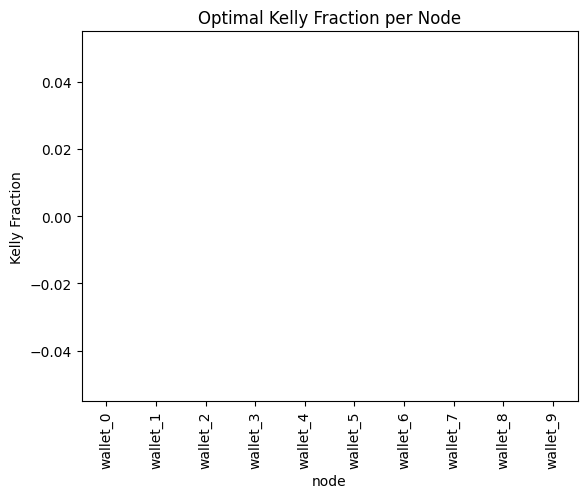

In [18]:
import matplotlib.pyplot as plt

# Average Kelly fraction by node
node_stats.plot.bar(x='node', y='kelly_fraction', legend=False)
plt.title('Optimal Kelly Fraction per Node')
plt.ylabel('Kelly Fraction')
plt.show()
